In [1]:
import numpy as np
import sympy as sp
from sympy import oo
import itertools
from functools import lru_cache as memorycache

# Display
from ipywidgets import interact, IntSlider, FloatSlider
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

def plotSympyFunction(f, bounds, **kwargs):
    xArr = np.linspace(bounds[0], bounds[1], 101)
    yArr = sp.lambdify(x, f)(xArr)
    plt.plot(xArr, yArr, **kwargs)

x = sp.symbols("x")
sp.init_printing()

# 1) Equilibrium Construction with Hermite Polynomials

The *lattice* Boltzmann equation can be derived by projecting the Boltzmann equation onto a finite dimensional subspace spanned by Hermite polynomials. The discrete lattice Boltzmann equilibrium is actually a projection of the continuous Maxwellian equilibrium onto this subspace. 

In this interactive Jupyter notebook we use *sympy* to systematically derive this discrete lattice Boltzmann equilibrium. 

We derive the essential concepts in 1D first, where the equations are much easier to read. 


##  1.1) Hermite Polynomials and Hermite series in 1D

Hermite polynomials are a set of orhogonal polynomials. Orthogonality is defined with respect to a scalar product, by requiring that $< P_i , P_j > = 0$ if $i \neq j$ for two polynomials $P_i$ and $P_j$. As we will see later, Hermite polynomials are orthogonal with respect to a special weighted scalar product. However, we start by first writing down the definition of the Hermite polynomials and later show that they are indeed orthogonal.

The n'th Hermite polynomial is defined as

$$ H^{(n)} = (-1)^n \frac{1}{W(x)} \frac{d^n}{dx^n} W(x)  $$

with a weight function $W$, that not coincidentally looks very similar to the Maxwellian distribution.

$$ W(x) = \frac{1}{\sqrt{2\pi}} e ^{-\frac{x^2}{2}}$$

Lets compute the first few Hermite polynomials using this definition. For this, the weight function derivative $\frac{d}{dx} W(x) = -x W(x)$ is helpful, i.e. differentiating the weight function yields a factor of $-x$.

$$ H^{(0)} = (-1)^0 \frac{1}{W(x)} \frac{d^0}{dx^0} W(x) =  \frac{1}{W(x)} W(x)= 1 $$
$$ H^{(1)} = (-1)^1 \frac{1}{W(x)} \frac{d}{dx} W(x)  = -\frac{1}{W(x)} (-x W(x)) = x$$
$$ H^{(2)} = (-1)^2 \frac{1}{W(x)} \frac{d}{dx} (-x W(x) ) = x^2 - 1 $$

Manually computing these polynomials gets tedious quickly, so lets implement this definition in *sympy*:

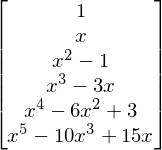

In [2]:
hermiteWeightFunction1D = sp.exp(- x*x / 2) / sp.sqrt(2 * sp.pi)

def hermite1D(n):
    if n == 0: 
        return 1
    W = hermiteWeightFunction1D
    result = (-1)**n * sp.diff(W, *[x] * n) / W
    return result.expand()

# Print the first 6 Hermite polynomials
sp.Matrix([hermite1D(i) for i in range(6)])

The Hermite polynomials form an ortogonal basis for the space of polynomials with respect to the weighted scalar product

$$ <f, g>_W = \int_{\mathbb{R}} f(x) g(x) \; W(x) \; dx .$$

The orthogonality property 
$$ <H^{(n)}, H^{(m)}>_W  = \delta_{nm} \, n! $$
is automatically fulfilled when the polynomials are constructed according to above rule, but can also be used directly to derive Hermite polynomials via an orthogonalization procedure.

*sympy* can do these Gaussian integrals for us, so lets check the orthogonality property by computing a few examples:

In [3]:
def weightedScalarProduct1D(f, g):
    return sp.integrate( f * g * hermiteWeightFunction1D, (x, -oo, oo) )

In [4]:
weightedScalarProduct1D(hermite1D(2), hermite1D(1))

In [5]:
weightedScalarProduct1D(hermite1D(3), hermite1D(3))

Note that Hermite polynomials, when defined as above, are not orthonormal. The scalar product of a Hermite polynomial with itself is not equal to one, but to the factorial of its order.

Since Hermite polynomials form a basis, every element of the function space can be expressed as a linear combination of Hermite polynomials. This is analogous to a Taylor or Fourier expansion, where in a Taylor expansion the monomials ($1, x, x^2, x^3, ...$) are used as basis elements and in a Fourier expansion the complex exponentials. We will see that Hermite polynomials are particularly well suited to expand Gaussian distribution functions.

We can expand arbitrary functions $f$ in the Hermite basis as
$$ f(x) = \sum_{n=0}^\infty b_n H^{(n)} .$$

To determine the coefficients $b_i$, we use a standard trick from linear algebra and multiply both sides by the weight function and another Hermite polynomial $H^{(m)}$ so that we can apply the orthogonality property.

$$ \int f(x) H^{(m)} W(x) \; dx =  \sum_{n=0}^\infty \int b_n H^{(n)} H^{(m)} W(x) \; dx  \; \Rightarrow \;
 \left<f, H^{(m)} \right>_W  =  \sum_{n=0}^\infty b_n \underbrace{ \left< H^{(n)}, H^{(m)} \right>_W }_{\delta_{nm} n!}   $$

The coefficients can then be determined with
$$ b_n = \frac{1}{n!} \left<f, H^{(n)} \right>_W $$

and the Hermite expansion for an arbitrary function $f$ reads
$$ f(x) = \sum_{n=0}^\infty \frac{1}{n!} \left<f, H^{(n)}\right>_W \, H^{(n)} $$

So far we only used straightforward linear algebra to represent a function in Hermite space. In the lattice Boltzmann literature a slightly different expansion is used. We deliberately showed the series expansion above in a very verbose way, so that one can easily compare the "standard linear algebra basis expansion" to the modified expansion that we are now going to present.

In this modified approach, the weight function and the normalization factor are moved into the expansion

$$ f(x) = W(x) \sum_{n=0}^\infty \frac{1}{n!} a_n H^{(n)} (x), $$

such that the formula for computing the expansion coefficients simplifies to

$$ a_n = \int H^{(n)} f \; dx. $$

Now we can see why the expansion was modified in this way:
If $f(x)$ is a probability distribution function, the integrals $\int x^n f(x)\; dx$ are its moments, e.g. for $n=1$ we get the first moment (expected value) of the distribution function. 
Since $H^{(n)}$ is a polynomial, the new coefficients $a_n$ are linear combinations of moments. 
In the LBM context, $f$ is chosen as the single particle distribution function, and its moments are physically meaningful quantities like density, velocity or energy flux.

Lets make use of the interactive computing environment and compute the Hermite expansions for a few functions.
Therefor we first have to implement the adapted expansion rules.

In [6]:
def hermiteCoefficient(f, n):
    return sp.integrate( hermite1D(n) * f, (x,-oo, oo) )

def hermiteApproximation(f, N):
    W = hermiteWeightFunction1D
    return W * sum(hermiteCoefficient(f, n) / sp.factorial(n) * hermite1D(n)
                   for n in range(N))

For demonstration, lets approximate the hat function by truncating the Hermite expansion after a few terms.

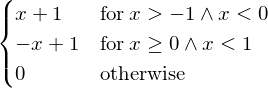

In [7]:
hat = sp.Piecewise((x+1, sp.And(x < 0 , x > -1) ), 
                   (-x+1, sp.And(x >= 0 , x < 1) ), 
                   (0, True))
hat

The following plot shows the hat function that is approximated by a truncated Hermite series. Use the slider widget to adjust the approximation order. The term displayed above the plot is the truncated approximation.

In [8]:
def approximateHat(n):
    approximation = hermiteApproximation(hat, n)
    display(approximation)
    plotSympyFunction(hat, (-2, 2), label='original')
    plotSympyFunction(approximation, (-2, 2), label='approx. n=%d' % (n,))
    plt.legend()
    plt.show()
    
interact(approximateHat, n=IntSlider(min=1,max=12,step=1,value=4));

interactive(children=(IntSlider(value=4, description='n', max=12, min=1), Output()), _dom_classes=('widget-interact',))

## 1.2) Hermite expansion preserves moments

The overall goal is to approximate the continuous Maxwellian equilibrium of the single particle distribution function as a truncated Hermite series. We haven't discussed yet, why we choose Hermite polynomials over other possible bases. Hermite expansions have the unique property that moments of the approximated function are preserved. Since the physically interesting quantities like density, momentum and energy are moments of the distribution function, this property ensures that important physical conservation laws like mass and momentum conservation not only hold for the Boltzmann equation but also for the discrete lattice Boltzmann approximation.

Specifically, a order $N$ Hermite approximation $\tilde{f}_N$ has the same first $N$ moments as the original function. 
For any polynomial $P(x)$ with degree not greater than $N$ we have
$$ \int P(x) \,\tilde{f}_N  \, dx = 
   \int P(x) W(x) \sum_{n=0}^{N} \frac{1}{n!} \left( \int H^{(n)} f \, dx \right) H^{(n)} \, dx = 
   \int P(x) \, f(x) \, dx. $$
The left hand side is the moment of the Hermite expansion, which is equal to the moment of the approximated function $f$.

**Proof**:

Since the polynomial has a degree $\le N$, it can be represented in the Hermite basis as 
$$P(x) = \sum_k^N c_k H^{(k)}(x).$$

Inserting this in the left hand side of the proposition gives:
$$ \int W(x) \sum_{n=0}^{N} \frac{1}{n!} \left( \int H^{(n)} f \, dx \right) H^{(n)} \sum_{k=0} c_k H^{(k)} \, dx $$
After regrouping

$$ \sum_{n=0}^{N} \sum_{k=0}^N c_k \left( \int H^{(n)} f \, dx \right) \frac{1}{n!} \int W(x) H^{(n)}   H^{(k)} \, dx $$

and using the orthogonality relation

$$ \sum_{n=0}^{N} \sum_{k=0}^N c_k^N \left( \int H^{(n)} f \, dx \right) \delta_{kn} $$

we obtain the right hand side of the proposition

$$  \int f(x) \sum_{n=0}^{N} c_n H^{(n)}  \, dx = \int f(x) \; P(x) \, dx  .$$

## 1.3) Gauss-Hermite Quadrature

Lattice Boltzmann methods store the evaluation of distribution function on a discrete set of points (stencil). Physical quantities, however, are moments of the distribution function. Thus we need a way to compute moments (integrals) using distribution function values on stencil points only. 
This can be done using Gauss quadrature. 
In general, a Gaussian quadrature rule approximates an integral by the finite sum

$$ \int W(x) \; f(x) \; dx \approx \sum\limits_{a=1}^{n} w_a \; f(x_a) $$

where $W(x)$ is the weight function of a scalar product, and the function to integrate is evaluated at the zeros of the corresponding orthogonal polynomials $x_a$. This approximation is exact if $f$ is a polynomial of degree $(2n-1)$ or less. This works for any set of orthogonal polynomials, especially also for Hermite polynomials.

The integration weights $w_a$ can be obtained as

$$ w_a = \frac{\left< H^{(n-1)}, H^{(n-1)} \right>_w }  
              {H^{(n-1)}(x_a) \;  \frac{d}{dx} H^{(n)} \rvert_{x_a} } $$

**Example:**

To approximate the integral $\int W(x) \; (x^2 - 3x + 4) \; dx$ of a second order polynomial, $(2n-1)=3$ evaluation points $x_a$ are required. These are the zeros of $H^{(3)}$. We can use *sympy* to find the evaluation points

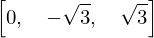

In [9]:
sp.solve(hermite1D(3))

and the corresponding weights $w_a$

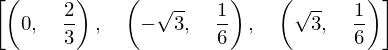

In [10]:
def gaussHermite(n):
    x_a = sp.solve(hermite1D(n))
    numerator = sp.integrate(hermiteWeightFunction1D * hermite1D(n-1)**2, (x,-oo, oo))
    denominator = hermite1D(n-1) * sp.diff(hermite1D(n), x)
    return [(evalPoint, (numerator / denominator).subs(x, evalPoint)) for evalPoint in x_a]
gaussHermite(3)

The ``gaussHermite`` function returns a list of tuples with ($x_a$, $w_a$).

Next, the integral is computed using the Gauss-Hermite approximation and compared to the exact solution obtained using symbolic integration. 

In [11]:
integrand = lambda x: (x**2 - 3*x + 4)

symbolicSolution = sp.integrate(integrand(x) * hermiteWeightFunction1D, (x,-oo,oo))
gaussHermiteSolution = sum(integrand(x_a) * w_a for x_a, w_a in gaussHermite(3))

print("Gauss-Hermite solution:", gaussHermiteSolution, "   Correct solution:", symbolicSolution)

assert gaussHermiteSolution == symbolicSolution

Gauss-Hermite solution: 5    Correct solution: 5


## 1.4) Hermite polynomials in 3D

In this section we generalize our implementation of Hermite polynomials to multiple dimensions.
We want to derive the discretized lattice Boltzmann equilibrium, by expanding the continuous single particle equilibrium distribution function as a Hermite series. Truncating this series at order 2 (or 3) gives us the standard discrete LB equilibrium of order 2 (or 3).

We first need the n-dimensional weight function $W$ defined as 

$$ W(\pmb{\xi}) = \frac{1}{(2\pi)^{D/2} } \exp\left(-\frac{\pmb{\xi}^2}{2}\right) $$

We switched notation here from $x$ to $\pmb{\xi}$ since we want to expand functions in the velocity $\xi$ later.$\pmb{\xi}$ is a N-dimensional vector and $\pmb{\xi}^2$ denotes its squared length. Otherwise only the prefactor has changed compared to the 1D weight function.

In [12]:
def weightFunction(x):
    """Multidimensional Hermite weight function. 
    Argument x is a tuple of spatial symbols e.g. symbols("x y z")"""
    dim = len(x)
    x = sp.sympify(x)
    xSq = sum(v**2 for v in x)   
    return sp.exp(-xSq / 2) / ( (2 * sp.pi) ** (sp.Rational(dim,2)) )

With this weight function the generalized hermite polynomials can be implemented.

In [13]:
def hermite(index, variables):
    """Multidimensional Hermite polynomial, where 'variables' is a tuple of spatial symbols 
    and 'index' is a sequence of indices in the variables. 
    e.g hermite((0,0,0), sp.symbols("x y z")) returns the 3rd order hermite polynomial H_xxx
    """
    order = len(index)
    if order==0 : return sp.Rational(1,1)
    w = weightFunction(variables)
    diffArgs = [variables[i] for i in index]
    result = (-1) ** order / w * sp.diff(w, *diffArgs)
    return result.expand()

Example: $H^{(3)}_{yyy}$

In [14]:
hermite((1,1,1), sp.symbols("x y z"))

In the paper this is shorterned using the tensor notation

$$ \mathbf{H}^{(n)}(\mathbf{ξ}) = (-1)^n \frac{1}{W(\mathbf{ξ})} \mathbf{\nabla}^{(n)} \; W(\mathbf{ξ}) $$

with the derivative tensor: $ \nabla^{(n)}_{ij\cdots k} = \partial_i \partial_j \cdots \partial_k $

Similarly to the 1D case, the adapted Hermite series expansion is used, where an unweighted scalar product is used to compute the coefficients, such that the coefficients are just the moments of the expanded function

$$f(\mathbf{ξ}) = W(\mathbf{ξ}) \sum_{n=0}^\infty \frac{1}{n!} \mathbf{a}^{(n)}_{i}  \mathbf{H}^{(n)}_{i}(\mathbf{ξ})$$

where an implicit sum is assumed over the multiindex $\mathbf{i}$. This very concise notation might get be easier to understand when looking at the following Python implementation.

In [15]:
@memorycache(maxsize=64)  # costly to compute.. cache in memory so subsequent calls are faster
def hermiteCoeff(f, index, variables):
    """Computes the coefficient a_index for the Hermite expansion of a function 'f'"""
    intArgs = [(v, -sp.oo, sp.oo) for v in variables]
    result = sp.integrate(hermite(index, variables) * f, *intArgs)
    return result.expand()

@memorycache(maxsize=8)
def hermiteExpansion(order, f, variables):
    """Compute Hermite expansion of function 'f' up to given 'order'"""
    nrVariables = len(variables)
    
    result = 0
    for currentOrder in range(order+1):
        termsForOrder = 0
        for index in itertools.product(*[range(nrVariables)]*currentOrder):
            termsForOrder += hermiteCoeff(f, index, variables)  * hermite(index, variables)

        result += termsForOrder / sp.factorial(currentOrder)
    return result * weightFunction(variables)

The lattice Boltzmann equilibrium can be obtained by projecting the continuous Maxwellian equilibrium onto the Hermite space of second (or third) order. The Maxwellian single particle equilibrium distribution is a central result of statistical mechanics and is given by

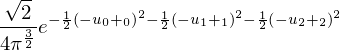

In [16]:
def continuousMaxwellianEquilibrium(dim=3):
    u = sp.symbols("u_:%d" % (dim,))
    ξ = sp.symbols("ξ_:%d" % (dim,))
    ρ = sp.symbols("ρ")
    θ = 1
    velSq = sum([(ξ_i - u_i) ** 2 for ξ_i, u_i in zip(ξ, u)])
    return ρ / (2 * sp.pi * θ) ** (sp.Rational(dim, 2)) * sp.exp(- velSq / (2 * θ))

continuousMaxwellianEquilibrium(dim=3)

where $u$ is the macroscopic velocity (mean of the bell-shaped distribution) and $ξ$ is the microscopic particle velocity.

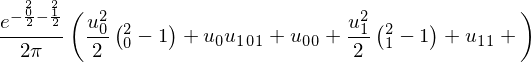

In [17]:
dim = 2
equilibriumHermiteSeries = hermiteExpansion(order=2, 
                                            f=continuousMaxwellianEquilibrium(dim),
                                            variables=sp.symbols("ξ_:%d" % (dim,)))
equilibriumHermiteSeries

Feel free to experiment with the expansion orders, or to switch from 2D to 3D in above code cell.

In the lattice Boltzmanm method evaluations of the distribution function are stored at a set of discrete velocitiy values (stencils). For this derivation we choose a product stencil of the 1D quadrature abscissae.
In this case the Gauss-Hermite quadrature weights are products of the 1D weights.

We already programmed the 1D function that gives us a mapping from evaluation point to quadrature weight,

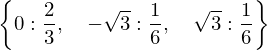

In [18]:
gaussHermiteQuadratureDict = {evalPoint: weight for evalPoint, weight in gaussHermite(3)}
gaussHermiteQuadratureDict

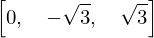

In [19]:
abscissae1D = list(gaussHermiteQuadratureDict.keys())
abscissae1D

so that we can build a product stencil out of these qudarature points

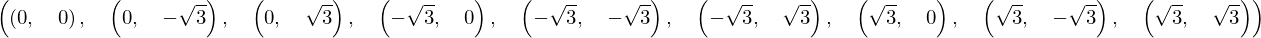

In [20]:
stencil = tuple(itertools.product(*[abscissae1D] * dim))
stencil

The weight of a stencil entry is given as product of the component weights:

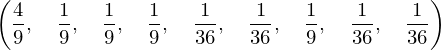

In [21]:
def weightForStencilEntry(d):
    result = 1
    for d_i in d:
        result *= gaussHermiteQuadratureDict[d_i]
    return result
weights = tuple(weightForStencilEntry(a) for a in stencil)
weights

Next we evalute the equilibrium at the computed stencil points. Instead of storing these evaluations directly, we usually work in LB methods with the quantities 

$$f_q := \frac{w_q}{W(ξ_q) } f(ξ_q)$$

This rescaling simplifies the calculation of moments (integrals). For example the first moment $\rho$ is then

$$ \int f(ξ_q) \,  dξ = \sum_q f_q $$

In the next cell we compute $f_q^{(eq)}$ using the definition above.

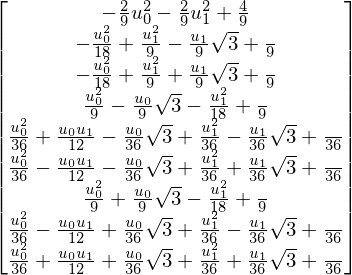

In [22]:
eq = tuple(w_i / weightFunction(d) * equilibriumHermiteSeries.subs({ξ_i: d_i for ξ_i, d_i in zip(sp.symbols("ξ_:3"), d)})
           for w_i, d in zip(weights, stencil))
sp.Matrix(eq)

In order to have integer abscissae, the velocities are usually rescaled by a factor of $\sqrt{3}$.
This finally gets us to the usual, well known discrete lattice Boltzmann equilibrium:

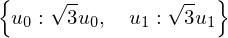

In [23]:
rescalingSubstitution = {u_i: u_i * sp.sqrt(3) for u_i in sp.symbols("u_:%d" % (dim,))}
rescalingSubstitution

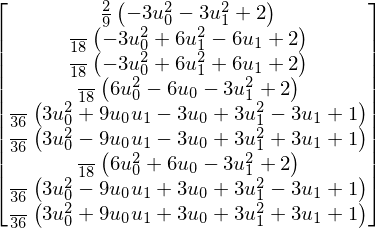

In [24]:
finalLbEquilibrium = sp.simplify(sp.Matrix(eq).subs(rescalingSubstitution))
finalLbEquilibrium

By adapting the dimension and Hermite approximation order in the cells above, second and third order equilibria for the D2Q9 and D3Q19 stencils can be obtained. 

Finally one can check that the moments can indeed be easily computed, e.g. the zeroth moment:

In [25]:
sum(finalLbEquilibrium).simplify()